In [59]:
import numpy as np
import sys, getopt
import os
from glob import glob
import piexif
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd
from sklearn.model_selection import train_test_split
from HitNet import HitNet
from TrackNet3 import TrackNet3
from keras.models import *
from keras.layers import *
import keras.backend as K
from keras import optimizers
from keras.activations import *
import tensorflow as tf
import cv2
import math

Using TensorFlow backend.
C:\Users\bb8\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\bb8\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\bb8\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\bb8\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Fu

In [2]:
BATCH_SIZE=3
HEIGHT=288
WIDTH=512
mag = 1
sigma = 2.5

#Return the values of accuracy, precision and recall
def evaluation(y_pred, y_true, tol):
    (TP, TN, FP1, FP2, FN) = outcome(y_pred, y_true, tol)
    try:
        accuracy = (TP + TN) / (TP + TN + FP1 + FP2 + FN)
    except:
        accuracy = 0
    try:
        precision = TP / (TP + FP1 + FP2)
    except:
        precision = 0
    try:
        recall = TP / (TP + FN)
    except:
        recall = 0
    return (accuracy, precision, recall)

In [3]:
def custom_loss(y_true, y_pred):
    loss = (-1)*(K.square(1 - y_pred) * y_true * K.log(K.clip(y_pred, K.epsilon(), 1)) + K.square(y_pred) * (1 - y_true) * K.log(K.clip(1 - y_pred, K.epsilon(), 1)))
    return K.mean(loss)

In [4]:
load_weights = './model906_30'
save_weights = './hitnet_weights'

tracknet_model = load_model(load_weights, custom_objects={'custom_loss':custom_loss})
model = HitNet(HEIGHT, WIDTH)

for l, layer in enumerate(tracknet_model.layers):
    if l >= len(model.layers)-2:
        break
    model.layers[l].set_weights(layer.get_weights())
    model.layers[l].trainable = False










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Final layer output shape: (None, 1)


In [5]:
model.compile(
    optimizer="adam", 
    loss="binary_crossentropy",
    metrics=['accuracy']
)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9, 288, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 288, 512)      5248      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 288, 512)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 288, 512)      2048      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 288, 512)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 288, 512)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 288, 512)      2048

In [ ]:
from sklearn.utils import class_weight

epochs = 10
dataDir = 'npy'
r = os.path.abspath(os.path.join(dataDir))
path = glob(os.path.join(r, '*.npy'))
num = len(path) / 2
idx = np.arange(num, dtype='int') + 1
print('Beginning training......')
for i in range(epochs):
    print('============epoch', i+1, '================')
    np.random.shuffle(idx)
    for j in idx:
        x_train = np.load(os.path.abspath(os.path.join(dataDir, 'x_data_' + str(j) + '.npy')))
        y_train = np.load(os.path.abspath(os.path.join(dataDir, 'y_data_' + str(j) + '.npy')))
        y_train = np.sum(y_train, axis=1)
        
        cw = class_weight.compute_class_weight('balanced', [0,1], y_train)
        model.fit(
            x_train, y_train, 
            batch_size=BATCH_SIZE, 
            epochs=5,
            class_weight=cw,
            shuffle=True,
            validation_split=0.1)
        
        del x_train
        del y_train
        
    #Save intermediate weights during training
    if (i + 1) % 3 == 0:
        model.save(save_weights + '_' + str(i + 1))

print('Saving weights......')
model.save(save_weights)
print('Done......')

Beginning training......
============epoch 1 ================
[0.56081081 4.61111111]
Train on 224 samples, validate on 25 samples
Epoch 1/5
141/224 [=================>............] - ETA: 4:43 - loss: 2.2892 - acc: 0.8582

# Pixel coordinates-only net

In [193]:
# Build model
dropout = 0.3
num_consec = 5
input_layer = Input(shape=(num_consec * 2,))
x = Dense(
    128, 
    activation='relu',
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(input_layer)
# x = Dropout(dropout)(x)
x = Dense(
    64, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)
x = Dense(
    32, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)
x = Dense(
    16, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)
output_layer = Dense(
    1, 
    activation='sigmoid',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)

model = Model(input_layer, output_layer)

In [205]:
opt = optimizers.Adam(lr=1e-6)
model.compile(
    optimizer='adam', 
    loss="binary_crossentropy",
    metrics=['accuracy']
)
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_71 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_72 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_73 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 17        
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
______________________________________________________

In [188]:
def diffuse(x):
    for i in range(x.shape[0]):
        val = 0
        if i > 0:
            val += x[i-1]
        if i < x.shape[0]-1:
            val += x[i+1]
        x[i] = max(x[i], val/2.)
    return x

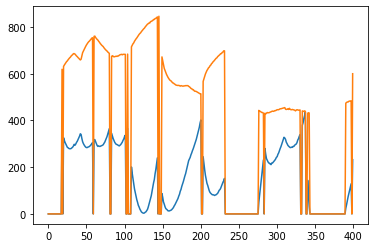

In [201]:
matches = list('match' + str(i) for i in range(1, 23))

x_train, y_train = [], []
for match in matches:
    for video in os.listdir('./data/%s/rally_video/' % match):
        rally, _ = os.path.splitext(video)
        trajectory = pd.read_csv('./data/%s/ball_trajectory/%s_ball.csv' % (match, rally))
        hit = pd.read_csv('./data/%s/shot/%s_hit.csv' % (match, rally))
        trajectory[trajectory.X == 0] = float('nan')
        trajectory[trajectory.Y == 0] = float('nan')
        
        trajectory = trajectory.assign(X=trajectory.X.interpolate(method='slinear'))
        trajectory = trajectory.assign(Y=trajectory.Y.interpolate(method='slinear'))
        trajectory.fillna(method='bfill', inplace=True)
        trajectory.fillna(method='ffill', inplace=True)
        
        x_list, y_list = [], []
        for i in range(num_consec):
            end = min(len(trajectory.X), len(hit.hit))-num_consec+i+1
            x = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))
            y = hit.hit[i:end].to_numpy().astype(float)
            x_list.append(x)
            y_list.append(y)
        
        x_t = np.hstack(x_list)
        y_t = np.sum(np.column_stack(y_list[1:-1]), axis=1)
        x_train.append(x_t)
        y_train.append(y_t)

x_train = np.vstack(x_train)
y_train = np.hstack(y_train)

Xb, Yb = trajectory.X.tolist(), trajectory.Y.tolist()
plt.plot(range(400), Yb[:400])
plt.plot(range(400), Xb[:400])
plt.show()

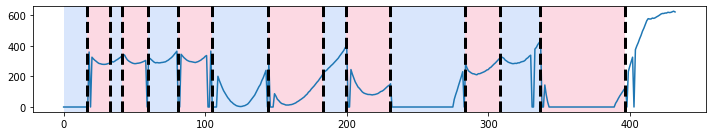

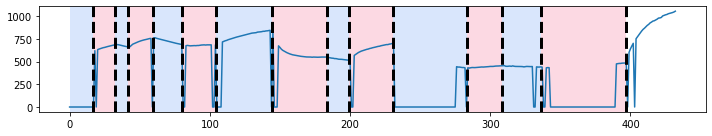

In [202]:
import ruptures as rpt
rpt.display(trajectory.Y, hit.index[hit.hit == 1].tolist(), hit.index[hit.hit == 1].tolist())
rpt.display(trajectory.X, hit.index[hit.hit == 1].tolist(), hit.index[hit.hit == 1].tolist())

plt.show()

In [203]:
import random

p = sum(y_train == 1) / sum(y_train == 0)
subsample = []
for i in range(x_train.shape[0]):
    if random.random() < p or y_train[i]:
        subsample.append(i)

x_sub = x_train[subsample]
y_sub = y_train[subsample]

In [206]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

# cw = class_weight.compute_class_weight('balanced', [0,1], y_train)
model.fit(
    x_sub, y_sub, 
    batch_size=64, 
    epochs=1000,
#     class_weight={0: cw[0] / sum(cw), 1: 1.5 * cw[1] / sum(cw)},
    shuffle=True,
    validation_split=0.1,
    verbose=1)

Train on 11549 samples, validate on 1284 samples
Epoch 1/1000
11549/11549 [==============================] - 3s 296us/step - loss: 0.2853 - acc: 0.8822 - val_loss: 0.3239 - val_acc: 0.8808
Epoch 2/1000
11549/11549 [==============================] - 1s 60us/step - loss: 0.2810 - acc: 0.8858 - val_loss: 0.3169 - val_acc: 0.8785
Epoch 3/1000
11549/11549 [==============================] - 1s 60us/step - loss: 0.2777 - acc: 0.8861 - val_loss: 0.3950 - val_acc: 0.8474
Epoch 4/1000
11549/11549 [==============================] - 1s 60us/step - loss: 0.2704 - acc: 0.8916 - val_loss: 0.3005 - val_acc: 0.8731
Epoch 5/1000
11549/11549 [==============================] - 1s 62us/step - loss: 0.2936 - acc: 0.8779 - val_loss: 0.3131 - val_acc: 0.8754
Epoch 6/1000
11549/11549 [==============================] - 1s 58us/step - loss: 0.2704 - acc: 0.8902 - val_loss: 0.3154 - val_acc: 0.8840
Epoch 7/1000
11549/11549 [==============================] - 1s 58us/step - loss: 0.2716 - acc: 0.8925 - val_loss: 0.

KeyboardInterrupt: 

In [213]:
y_pred = np.round(model.predict(x_train) > 0.9)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     58817
         1.0       0.80      0.65      0.72      6431

    accuracy                           0.95     65248
   macro avg       0.88      0.82      0.84     65248
weighted avg       0.95      0.95      0.95     65248



In [180]:
import keras
keras.models.save_model(model, './hitnet_weights')

# Incorporating pose and court information

In [12]:
class Pose:
    skeleton = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head
        (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
        (6, 12), (5, 11), (11, 12),  # Body
        (11, 13), (12, 14), (13, 15), (14, 16)
    ]

    joint_names = [
        "nose", "left_eye", "right_eye", "left_ear", "right_ear", 
        "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", 
        "left_wrist", "right_wrist", "left_hip", "right_hip", 
        "left_knee", "right_knee", "left_ankle", "right_ankle" ]
    
    def __init__(self, kplines=[]):
        if not kplines:
            return
        
        keypoints = []
        for line in kplines:
            i, px, py, score = [float(x) for x in line.split()]
            keypoints.append((int(i), np.array([px, py])))
        self.init_from_kp(keypoints)
    
    def init_from_kparray(self, kparray):
        kp = np.array(kparray).reshape((17, 2))
        keypoints = []
        for i in range(17):
            keypoints.append((i, kp[i]))
        self.init_from_kp(keypoints)
        
    # Each pose has 17 key points, representing the skeleton
    def init_from_kp(self, keypoints):
        # Keypoints should be tuples of (id, point)
        self.kp = np.empty((17, 2))
        self.kp[:] = np.NaN

        for i, p in keypoints:
            self.kp[i] = p
        
        self.bx = [min(self.kp[:, 0]), max(self.kp[:, 0])]
        self.by = [min(self.kp[:, 1]), max(self.kp[:, 1])]
        
    
    def draw_skeleton(self, img, colour=(0, 128, 0), thickness=5):
        cimg = img.copy()
        for line in self.skeleton:
            X, Y = self.kp[line[0]], self.kp[line[1]]
            if any(np.isnan(X)) or any(np.isnan(Y)):
                continue
            p0, p1 = tuple(X.astype(int)), tuple(Y.astype(int))
            # For the legs, colour them and the ankles separately
            if line == (13, 15) or line == (14, 16):
                cimg = cv2.line(cimg, p0, p1, (0, 128, 128), thickness)
                cimg = cv2.circle(cimg, p1, 3, (128, 128, 0), thickness=-1)
            else:
                cimg = cv2.line(cimg, p0, p1, colour, thickness)
        return cimg
    
    def get_base(self):
        # Returns the midpoint of the two ankle positions
        return (self.kp[15] + self.kp[16]) / 2.
    
    def get_centroid(self):
        n = 0
        p = np.zeros((2,))
        for i in range(17):
            if any(np.isnan(self.kp[i])):
                continue
            
            n += 1
            p += self.kp[i]
        return p / n
    
    def can_reach(self, p, epsx=1.5, epsy=1.5):
        # if within (1+/-eps) of the bounding box then we can reach it
        dx, dy = self.bx[1] - self.bx[0], self.by[1] - self.by[0]
        return self.bx[0] - epsx * dx < p[0] < self.bx[1] + epsx * dx and \
               self.by[0] - epsy * dy < p[1] < self.by[1] + epsy * dy
    
'''
The court looks like this:
A-B-----C-----*-D
| |     |     | |
E-*-----*-----*-*
| |     |     | |
| |     |     | |
| |     |     | |
F---------------*
| |           | |
| |           | |
*---------------*
| |     |     | |
| |     |     | |
| |     |     | |
*-*-----*-----*-*
| |     |     | |
G-*-----*-----*-X

AC/AD = 1/2
AB/AD = 1.5/20
AE/AF = 2.5/15.5
AF/AG = 15.5/44
'''
class Court:
    eps = 0.01
    def __init__(self, corners):
        # The corners must be in the order ADG (or some symmetry of it)
        npcorners = np.stack([np.array(c) for c in corners])
        lcorners = np.array([[0, 0], [1, 0], [0, 1], [1,1]])
        H, mask = cv2.findHomography(lcorners, npcorners, cv2.RANSAC, 2.0)
        self.H = H
        self.inv_H = np.linalg.inv(H)
        
        def to_coord(u, v):
            X = H @ np.array([u, v, 1])
            return X[:2] / X[2]
        
        # ratios of the shorter side
        self.sr = [0, 1.5/20, 1./2, 1-1.5/20, 1]
        self.lr = [0, 2.5/44, 15.5/44, 1/2, 1-15.5/44, 1-2.5/44, 1]
        self.points = []
        for v in self.lr:
            for u in self.sr:
                p = to_coord(u, v)
                self.points.append(p)
                
        self.lines = []
        # Draw the horizontals
        for v in self.lr:
            for i in range(1, len(self.sr)):
                up, u = self.sr[i-1], self.sr[i]
                p, c = to_coord(up, v), to_coord(u, v)
                self.lines.append((p, c))
        
        # Draw the verticals, but skip one line
        for u in self.sr:
            for i in range(1, len(self.lr)):
                vp, v = self.lr[i-1], self.lr[i]
                if (vp == 1./2 or v == 1./2) and u == 1./2:
                    continue
                p, c = to_coord(u, vp), to_coord(u, v)
                self.lines.append((p, c))
    
    def draw_lines(self, img):
        cimg = img.copy()
        colour = (0, 0, 255)
        thickness = 3
        for line in self.lines:
            p0, p1 = tuple(line[0].astype(int)), tuple(line[1].astype(int))
            cimg = cv2.line(cimg, p0, p1, colour, thickness)
        return cimg
    
    def pixel_to_court(self, p):
        x = self.inv_H @ np.array([p[0], p[1], 1])
        return x[:2] / x[2]
    
    def in_court(self, p):
        # 0 if not in court, 1 if in upper half, 2 if in lower half
        x = self.pixel_to_court(p)
        if not (-self.eps < x[0] < 1 + self.eps):
            return 0
        if not (-self.eps < x[1] < 1 + self.eps):
            return 0
        
        return 1 + (x[1] > 0.5 - self.eps)
    
    def draw_hit(self, img, pos, colour=(255,0,0)):
        # pos must be a vec in [0,1]^2 representing position on the 2d court
        centre = (int(pos[0] * img.shape[1]), int((1-pos[1]) * img.shape[0]))
        radius = 6
        thickness = -1
        return cv2.circle(img, centre, radius, colour, thickness)

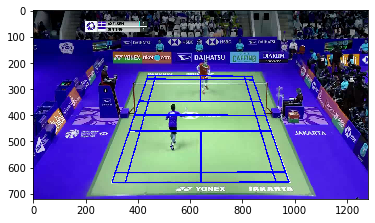

In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

match = 'match21'
rally = '1_02_01'

def read_court(filename):
    file = open(filename, 'r')
    coordinates = [[float(x) for x in line.split(';')] for line in file]
    return coordinates

court_pts = read_court('./data/%s/court/%s.out' % (match, rally))

corners = [court_pts[1], court_pts[2], court_pts[0], court_pts[3]]
frames = [frame]
    
def draw_court(corners):
    # Draws the court once we have the three corners
    court = Court(corners)
    frames[-1] = court.draw_lines(frames[-1])
    plt.imshow(frames[-1])
   
cap = cv2.VideoCapture('./data/%s/rally_video/%s.mp4' % (match, rally))
if cap.isOpened() is False:
    print('Error opening video stream or file')
    
ret, frame = cap.read()
fig = plt.figure()

draw_court(corners)
court = Court(corners)

In [18]:
from collections import defaultdict

poses = open('./data/%s/poses/%s.out' % (match, rally))

filtered_poses = defaultdict(dict)

frame_id = -1
pose_lines = []

def filter_pose(fid, kplines):
    if not kplines:
        return
    pose = Pose(kplines)
    in_court = court.in_court(pose.get_base())# or court.in_court(pose.get_centroid())
    if in_court:
        filtered_poses[fid][in_court] = pose
        
def process_poses(fid, lines):
    if not lines:
        return
    
    kplines = []
    for line in lines:
        if 'pose' in line:
            filter_pose(fid, kplines)
            kplines = []
        else:
            kplines.append(line)
    filter_pose(fid, kplines)
            
for line in poses:
    if 'frame' in line:
        process_poses(frame_id, pose_lines)
        pose_lines = []
        frame_id += 1
    else:
        pose_lines.append(line)
process_poses(frame_id, pose_lines)

In [23]:
import csv

frame_lim = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for pid, side in enumerate(['bottom', 'top']):
    filename = './data/%s/poses/%s_%s.csv' % (match, rally, side)
    file = open(filename, 'w')
    player_writer = csv.writer(file)
    
    row_names = ['frame']
    for joint in Pose.joint_names:
        row_names.append(joint + '_x')
        row_names.append(joint + '_y')
        
    player_writer.writerow(row_names)
    for fid in range(frame_lim):
        row = [fid] + [np.NaN] * 34
        if pid + 1 in filtered_poses[fid]:
            for i, z in enumerate(filtered_poses[fid][pid + 1].kp):
                row[2*i+1] = z[0]
                row[2*i+2] = z[1]
        player_writer.writerow([str(s) for s in row])
    file.close()
    
    # Lets interpolate all the missing values
    player = pd.read_csv(filename)
    player.interpolate(method='slinear', inplace=True)
    player.fillna(method='bfill', inplace=True)
    player.to_csv(filename, index=False)

In [26]:
# Write the hits to video, draw a dot right as the shuttle is struck
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
bottom_player = pd.read_csv('./data/%s/poses/%s_bottom.csv' % (match, rally))
top_player = pd.read_csv('./data/%s/poses/%s_top.csv' % (match, rally))
players = [bottom_player, top_player]

outvid = cv2.VideoWriter('test.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, (width, height))

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
import tqdm.notebook as tq

for i in tq.tqdm(range(frame_lim)):
    ret, frame = cap.read()
    frame = court.draw_lines(frame)
    player_poses = []
    for j in range(2):
        xy = players[j].iloc[i].to_list()[1:]
        pose = Pose()
        pose.init_from_kparray(xy)
        player_poses.append(pose)
        frame = pose.draw_skeleton(frame, colour=(128, 128 + j * 127, 128))  
    outvid.write(frame)

In [412]:
import os
matches = list('match' + str(i) for i in range(1, 23))

for match in matches:
    for video in os.listdir('./data/%s/rally_video/' % match):
        rally, _ = os.path.splitext(video)
        
        court_pts = read_court('./data/%s/court/%s.out' % (match, rally))
        corners = [court_pts[1], court_pts[2], court_pts[0], court_pts[3]]
        court = Court(corners)

        poses = open('./data/%s/poses/%s.out' % (match, rally))
        filtered_poses = defaultdict(dict)
        frame_id = -1
        pose_lines = []

        for line in poses:
            if 'frame' in line:
                process_poses(frame_id, pose_lines)
                pose_lines = []
                frame_id += 1
            else:
                pose_lines.append(line)
        process_poses(frame_id, pose_lines)

        cap = cv2.VideoCapture('./data/%s/rally_video/%s.mp4' % (match, rally))
        if cap.isOpened() is False:
            print('Error opening video stream or file')

        frame_lim = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        for pid, side in enumerate(['bottom', 'top']):
            filename = './data/%s/poses/%s_%s.csv' % (match, rally, side)
            file = open(filename, 'w')
            player_writer = csv.writer(file)

            row_names = ['frame']
            for joint in Pose.joint_names:
                row_names.append(joint + '_x')
                row_names.append(joint + '_y')

            player_writer.writerow(row_names)
            for fid in range(frame_lim):
                row = [fid] + [np.NaN] * 34
                if pid + 1 in filtered_poses[fid]:
                    for i, z in enumerate(filtered_poses[fid][pid + 1].kp):
                        row[2*i+1] = z[0]
                        row[2*i+2] = z[1]
                player_writer.writerow([str(s) for s in row])
            file.close()

            # Lets interpolate all the missing values
            player = pd.read_csv(filename)
            player.interpolate(method='slinear', inplace=True)
            player.fillna(method='bfill', inplace=True)
            player.fillna(method='ffill', inplace=True)
            player.to_csv(filename, index=False)

# Creating a neural net that uses pose and court information

In [51]:
import os
import pandas as pd
import numpy as np

def read_court(filename):
    file = open(filename, 'r')
    coordinates = [[float(x) for x in line.split(';')] for line in file]
    return coordinates

num_consec = 5
matches = list('match' + str(i) for i in range(1, 23))

x_train, y_train = [], []
for match in matches:
    for video in os.listdir('./data/%s/rally_video/' % match):
        rally, _ = os.path.splitext(video)
        trajectory = pd.read_csv('./data/%s/ball_trajectory/%s_ball.csv' % (match, rally))
        hit = pd.read_csv('./data/%s/shot/%s_hit.csv' % (match, rally))
        trajectory[trajectory.X == 0] = float('nan')
        trajectory[trajectory.Y == 0] = float('nan')
        
        trajectory = trajectory.assign(X=trajectory.X.interpolate(method='slinear'))
        trajectory = trajectory.assign(Y=trajectory.Y.interpolate(method='slinear'))
        trajectory.fillna(method='bfill', inplace=True)
        trajectory.fillna(method='ffill', inplace=True)
        
        bottom_player = pd.read_csv('./data/%s/poses/%s_bottom.csv' % (match, rally))
        top_player = pd.read_csv('./data/%s/poses/%s_top.csv' % (match, rally))
        bottom_player.drop('frame', axis=1, inplace=True)
        top_player.drop('frame', axis=1, inplace=True)
        bottom_player.fillna(0, inplace=True)
        top_player.fillna(0, inplace=True)
        
        x_list, y_list = [], []
        court_pts = read_court('./data/%s/court/%s.out' % (match, rally))
        corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
        for i in range(num_consec):
            end = min(len(trajectory.X), len(hit.hit))-num_consec+i+1
            x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))
            
            # Reduce amount of data by averaging coordinate values
#             bottom_x = np.median(bottom_player.values[i:end][:, ::2], axis=1)
#             bottom_y = np.median(bottom_player.values[i:end][:, 1::2], axis=1)
#             top_x = np.median(top_player.values[i:end][:, ::2], axis=1)
#             top_y = np.median(top_player.values[i:end][:, 1::2], axis=1)
            
#             x_pose = np.vstack([bottom_x, bottom_y, top_x, top_y]).T
#             x_pose = np.hstack([bottom_player.values[i:end], top_player.values[i:end]])
#             x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])
            x = np.hstack([x_bird, np.array([corners for j in range(i, end)])])

            y = hit.hit[i:end].to_numpy().astype(float)
            x_list.append(x)
            y_list.append(y)        

        x_t = np.hstack(x_list)
        y_t = np.sum(np.column_stack(y_list[1:-1]), axis=1)
        x_train.append(x_t)
        y_train.append(y_t)

x_train = np.vstack(x_train)
y_train = np.hstack(y_train)

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

In [60]:
from keras.models import *
from keras.layers import *
import keras.backend as K
from keras import optimizers
from keras.activations import *
import tensorflow as tf
import cv2
import math

dropout = 0.1

input_layer = Input(shape=(x_train[0].shape[0],))
x = Dense(
    128, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-9)
)(input_layer)
# x = ActivityRegularization(l1=1e-9)(x)
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
x = Dense(
    64, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-9)
)(x)
# x = ActivityRegularization(l1=1e-9)(x)
# x = ActivityRegularization()(x)
# x = BatchNormalization()(x)

x = Dense(
    16, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)
# x = ActivityRegularization(l1=1e-11)(x)
# x = BatchNormalization()(x)

x = Dense(
    8, 
    activation='relu',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)
# x = BatchNormalization()(x)

output_layer = Dense(
    1, 
    activation='sigmoid',
#     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=1e-7)
)(x)

model = Model(input_layer, output_layer)

In [82]:
opt = optimizers.Adam(lr=1e-6)
model.compile(
    optimizer=opt, 
    loss="binary_crossentropy",
    metrics=['accuracy']
)
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 50)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 128)               6528      
_________________________________________________________________
dense_47 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_48 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_49 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 9         
Total params: 15,969
Trainable params: 15,969
Non-trainable params: 0
______________________________________________________

In [76]:
import random

p = sum(y_train == 1) / sum(y_train == 0)
subsample = []
for i in range(x_train.shape[0]):
    if random.random() < p or y_train[i]:
        subsample.append(i)

x_sub = x_train[subsample]
y_sub = y_train[subsample]

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_sub, y_sub, test_size=0.1, shuffle=True)

In [83]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

model.fit(
    x_tr, y_tr, 
    batch_size=32, 
    epochs=1000,
    shuffle=True,
    validation_data=[x_val, y_val],
    verbose=1)

Train on 11587 samples, validate on 1288 samples
Epoch 1/1000
11587/11587 [==============================] - 3s 265us/step - loss: 0.1577 - acc: 0.9415 - val_loss: 0.1955 - val_acc: 0.9325
Epoch 2/1000
11587/11587 [==============================] - 1s 79us/step - loss: 0.1577 - acc: 0.9416 - val_loss: 0.1955 - val_acc: 0.9317
Epoch 3/1000
11587/11587 [==============================] - 1s 78us/step - loss: 0.1577 - acc: 0.9422 - val_loss: 0.1955 - val_acc: 0.9309
Epoch 4/1000
11587/11587 [==============================] - 1s 78us/step - loss: 0.1577 - acc: 0.9416 - val_loss: 0.1954 - val_acc: 0.9325
Epoch 5/1000
11587/11587 [==============================] - 1s 86us/step - loss: 0.1576 - acc: 0.9417 - val_loss: 0.1955 - val_acc: 0.9317
Epoch 6/1000
11587/11587 [==============================] - 1s 76us/step - loss: 0.1576 - acc: 0.9413 - val_loss: 0.1955 - val_acc: 0.9301
Epoch 7/1000
11587/11587 [==============================] - 1s 79us/step - loss: 0.1576 - acc: 0.9422 - val_loss: 0.

KeyboardInterrupt: 

In [93]:
y_pred = np.round(model.predict(x_train) > 0.8)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     58817
         1.0       0.77      0.86      0.81      6431

    accuracy                           0.96     65248
   macro avg       0.88      0.92      0.90     65248
weighted avg       0.96      0.96      0.96     65248



In [84]:
import keras
keras.models.save_model(model, './hitnet_plus_court_model')